# Logistic Regression


## Imports


In [99]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
%autoreload 2

In [101]:
from util import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix ,f1_score
import seaborn as sns
from sklearn.utils import shuffle
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

NUM_FOLDS = 10


In [102]:
model_name = "Logistic Regression"

## Reading the data


In [103]:
X, X_test, y, y_test = get_data(path='../data/train_pca_20.csv',)

In [104]:
len(X)

100000

In [105]:
sampling_flag = int(input("Enter 1 for undersampling, 2 for oversampling, otherwise for no sampling: "))

Class distribution: Counter({0: 89951, 1: 10049})
Class distribution after resampling: Counter({0: 89951, 1: 10049})
(100000, 20)
(100000,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


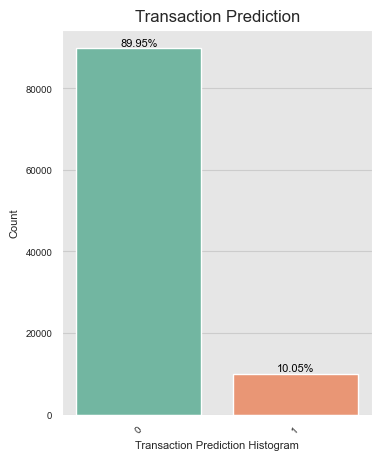

In [106]:
print("Class distribution:", Counter(y))
if sampling_flag == 1:
    # Check class distribution before undersampling

    # Define the undersampler
    undersampler = RandomUnderSampler(random_state=42)

    # Apply undersampling
    X, y = undersampler.fit_resample(X, y)

elif sampling_flag == 2:
    sampling_strategy = 'auto'#"minority"
    smote = SMOTE(random_state=42,n_jobs=-1,sampling_strategy=sampling_strategy)
    X, y = smote.fit_resample(X, y)
# check the new class distribution
print("Class distribution after resampling:", Counter(y))
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))
data = pd.concat([X, y], axis=1)
# target variable analysis
plt.figure(figsize=(4, 5))
sns.countplot(x="target", data=data, palette='Set2', ax=plt.gca())
# add percentages
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '{:1.2f}%'.format(100*p.get_height()/len(data)),
                   fontsize=8, color='black', ha='center', va='bottom')
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Transaction Prediction Histogram', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.title('Transaction Prediction')
plt.axis('tight')
temp = ''
if sampling_flag == 1:
    temp = 'under'
elif sampling_flag == 2:
    temp = 'over'
else:
    temp = 'no'
# plt.savefig(f'../images/{model_name}/transaction_distribution_after_{temp}_sampling.png',
#             dpi=300, bbox_inches='tight')
plt.show()


In [107]:
# standardize the data
X = standardize_features(X)
X_test = standardize_features(X_test)

In [108]:
X.columns

Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16',
       'pca17', 'pca18', 'pca19'],
      dtype='object')

In [109]:
# get the percentage of class 1 and class 0
number_of_ones = len(y[y == 1])
number_of_zeros = len(y[y == 0])
total = len(y)
percentage_of_ones = number_of_ones / total
percentage_of_zeros = number_of_zeros / total
print(f"Percentage of ones: {percentage_of_ones}")
print(f"Percentage of zeros: {percentage_of_zeros}")

Percentage of ones: 0.10049
Percentage of zeros: 0.89951


In [110]:
class_weight = None
# class_weight = "balanced"
# class_weight = {0: 1/percentage_of_zeros, 1: 1/percentage_of_ones}
# class_weight = {0: 1-percentage_of_zeros, 1: 1-percentage_of_ones}

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Training the model


In scikit-learn, `LogisticRegression` is a class that implements logistic regression for classification tasks. It has several parameters that control its behavior during training and prediction. Here are some of the most commonly used parameters:

1. **penalty**: Specifies the norm used in the penalization. It could be `'l1'` for L1 regularization, `'l2'` for L2 regularization, or `'none'` for no regularization. Default is `'l2'`, `'elasticnet'`: both L1 and L2 penalty terms are added.

2. **C**: Inverse of regularization strength; smaller values specify stronger regularization. Default is `1.0`.

3. **solver**: Algorithm to use in the optimization problem. It could be `'newton-cg'`, `'lbfgs'`, `'liblinear'`, `'sag'`, or `'saga'`. Default is `'lbfgs'`.

4. **max_iter**: Maximum number of iterations taken for the solvers to converge. Default is `100`.

5. **multi_class**: Strategy for handling multiple classes. It could be `'ovr'` (one-vs-rest) or `'multinomial'`. Default is `'ovr'`.

6. **random_state**: Seed used by the random number generator.

7. **tol**: Tolerance for stopping criteria.

8. **verbose**: Controls the verbosity.

9. **class_weight**: Weights associated with classes. Useful for imbalanced datasets.

10. **warm_start**: If set to `True`, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. Default is `False`.

These are some of the main parameters of `LogisticRegression`, but there are more. You can find a comprehensive list in the scikit-learn documentation for `LogisticRegression`.

In [112]:
lr = LogisticRegression(C=1, max_iter=10000,random_state=42,class_weight=class_weight)
lr.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10000, random_state=42)

`cross_validate` function in scikit-learn is used for evaluating estimator performance using cross-validation. It takes several parameters to customize its behavior. Here are the main parameters:

1. **estimator**: This is the machine learning estimator (model) that you want to evaluate.

2. **X**: The feature matrix (data) to fit the model on.

3. **y**: The target values (labels) corresponding to X.

4. **cv**: The cross-validation strategy. It could be an integer specifying the number of folds in a KFold, a cross-validation splitter, or an iterable yielding train/test splits.

5. **scoring**: A single string or a callable to evaluate the predictions on the test set. For example, `'accuracy'`, `'precision'`, `'recall'`, `'f1'`, etc.

6. **n_jobs**: The number of CPU cores to use for computation. `-1` means using all processors.

7. **return_train_score**: Whether to include training scores in the output. Default is `False`.

8. **return_estimator**: Whether to return the fitted estimators for each split. Default is `False`.

9. **verbose**: Controls the verbosity: the higher, the more messages.

10. **fit_params**: Parameters to pass to the `fit` method of the estimator.

11. **pre_dispatch**: Controls the number of jobs dispatched during parallel execution. `-1` means all processes are dispatched at once, `2` means that two processes are dispatched, and `None` means that as many processes as CPUs are used.

These are the main parameters, but there are a few more which you can find in the scikit-learn documentation for the `cross_validate` function.

In [113]:
cv_results = cross_validate(lr, X_train, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'],pre_dispatch=-1)

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

accuracy:  0.8999499999999999
f1_macro:  0.4736703591995319
f1_micro:  0.8999499999999999


In [114]:
logistic_predictions = lr.predict(X_val)
print("Logistic Regression Predictions:", logistic_predictions)
logistic_accuracy = accuracy_score(y_val, logistic_predictions)
print("Logistic Regression Accuracy:", logistic_accuracy)

print("Classification Report:")
print(classification_report(y_val, logistic_predictions))

Logistic Regression Predictions: [0 0 0 ... 0 0 0]
Logistic Regression Accuracy: 0.89775
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17955
           1       0.00      0.00      0.00      2045

    accuracy                           0.90     20000
   macro avg       0.45      0.50      0.47     20000
weighted avg       0.81      0.90      0.85     20000



c:\Users\peter\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Analysis


### Feature Importance Plot

A feature importance plot shows the importance of each feature in the model. It can be used to identify the most important features and to understand the impact of each feature on the model's predictions.


In [115]:
# coefficient for each feature
lr.coef_.shape

(1, 20)

The weight of the coefficients in the logistic regression model can be used as a measure of feature importance. The higher the absolute value of the coefficient, the more important the feature is in the model. We can plot the coefficients to visualize the feature importance.
Notice that we take the absolute value of the coefficients to consider both positive and negative impacts of the features on the model's predictions.

   feature  importance
10   pca10        0.15
5     pca5        0.12
18   pca18        0.12
11   pca11        0.07
7     pca7        0.07
19   pca19        0.07
0     pca0        0.06
1     pca1        0.05
15   pca15        0.05
4     pca4        0.04
12   pca12        0.04
6     pca6        0.03
14   pca14        0.03
2     pca2        0.03
8     pca8        0.02
3     pca3        0.02
13   pca13        0.02
9     pca9        0.01
16   pca16        0.00
17   pca17        0.00


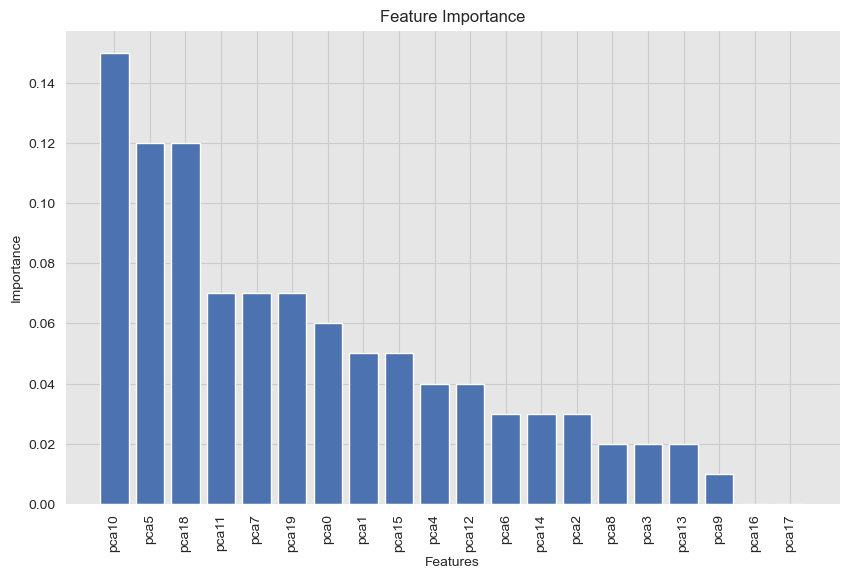

In [116]:
# Get the feature importance
importance = (abs(lr.coef_[0]) / np.abs(lr.coef_[0]).sum()).round(2)

feature_importance = get_feature_importance(
    features=X_train.columns, importance=importance)
print(feature_importance)

plt = get_feature_importance_plot(
    feature_importance, modelname='Logistic Regression',save=False)
plt.show()


Remove the unimportant feature

In [117]:
X_train_temp = X_train.copy()
X_val_temp = X_val.copy()

In [118]:
# loop over feature_importance and print out the features with importance > 0.1
for i in range(len(feature_importance)):
    if feature_importance['importance'][i] ==0:
        # remove the feature from the training data that has importance < 0.1
        X_train_temp = X_train_temp.drop(
            columns=feature_importance['feature'][i])
        X_val_temp = X_val_temp.drop(
            columns=feature_importance['feature'][i])
len(X_train_temp.columns)

18

In [119]:
lr_temp = LogisticRegression(C=1, max_iter=10000,random_state=42,class_weight=class_weight)
lr_temp.fit(X_train_temp, y_train)
cv_results = cross_validate(lr_temp, X_train_temp, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())


accuracy:  0.8999499999999999
f1_macro:  0.4736703591995319
f1_micro:  0.8999499999999999


   feature  importance
10   pca10        0.15
16   pca18        0.12
5     pca5        0.12
17   pca19        0.07
7     pca7        0.07
11   pca11        0.07
0     pca0        0.06
1     pca1        0.05
15   pca15        0.05
4     pca4        0.04
12   pca12        0.04
6     pca6        0.03
14   pca14        0.03
2     pca2        0.03
8     pca8        0.02
3     pca3        0.02
13   pca13        0.02
9     pca9        0.01


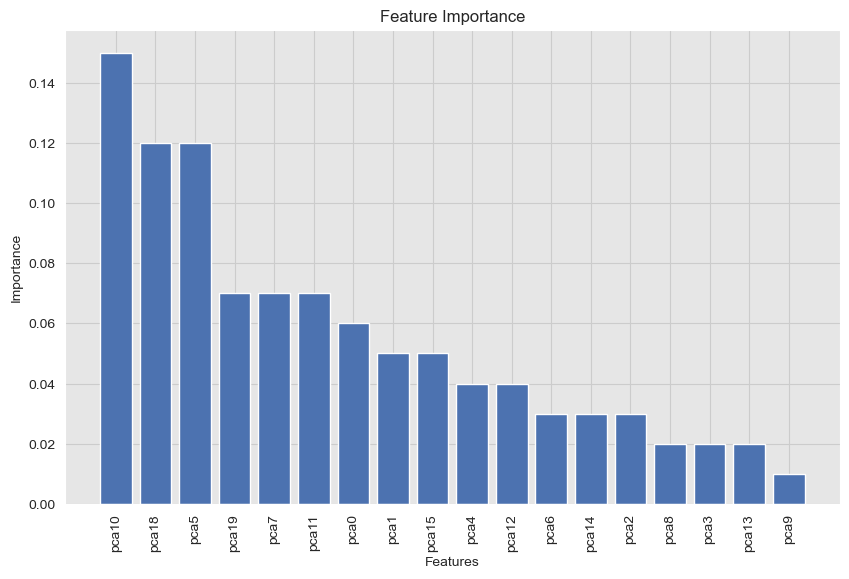

In [120]:
# Get the feature importance
importance = (abs(lr_temp.coef_[0]) / np.abs(lr_temp.coef_[0]).sum()).round(2)

feature_importance = get_feature_importance(
    features=X_train_temp.columns, importance=importance)
print(feature_importance)

plt = get_feature_importance_plot(
    feature_importance, modelname='Logistic Regression',save=False)
plt.show()


### Learning Curves Plot

show the training error (Ein) and validation error (Eval) as a function of the training set size

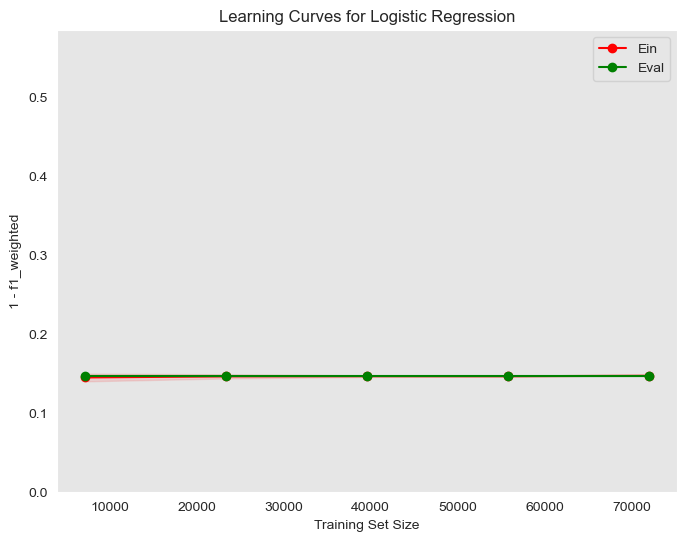

In [121]:
plt = get_learning_curve_plot(estimator=LogisticRegression(
    C=0.1, max_iter=10000, solver='saga',class_weight=class_weight), X=X_train, y=y_train, cv=NUM_FOLDS, modelname='Logistic Regression')
plt.show()


### Partial Dependence Plot

A partial dependence plot shows the relationship between a feature and the model's predictions while holding all other features constant. It can be used to understand the impact of a single feature on the model's predictions i.e. PDPs show the average effect on predictions as the value of feature changes.

From the plots, we may see the type of the relationship between a feature and a prediction. Some relationships may look linear whereas other are more complex.


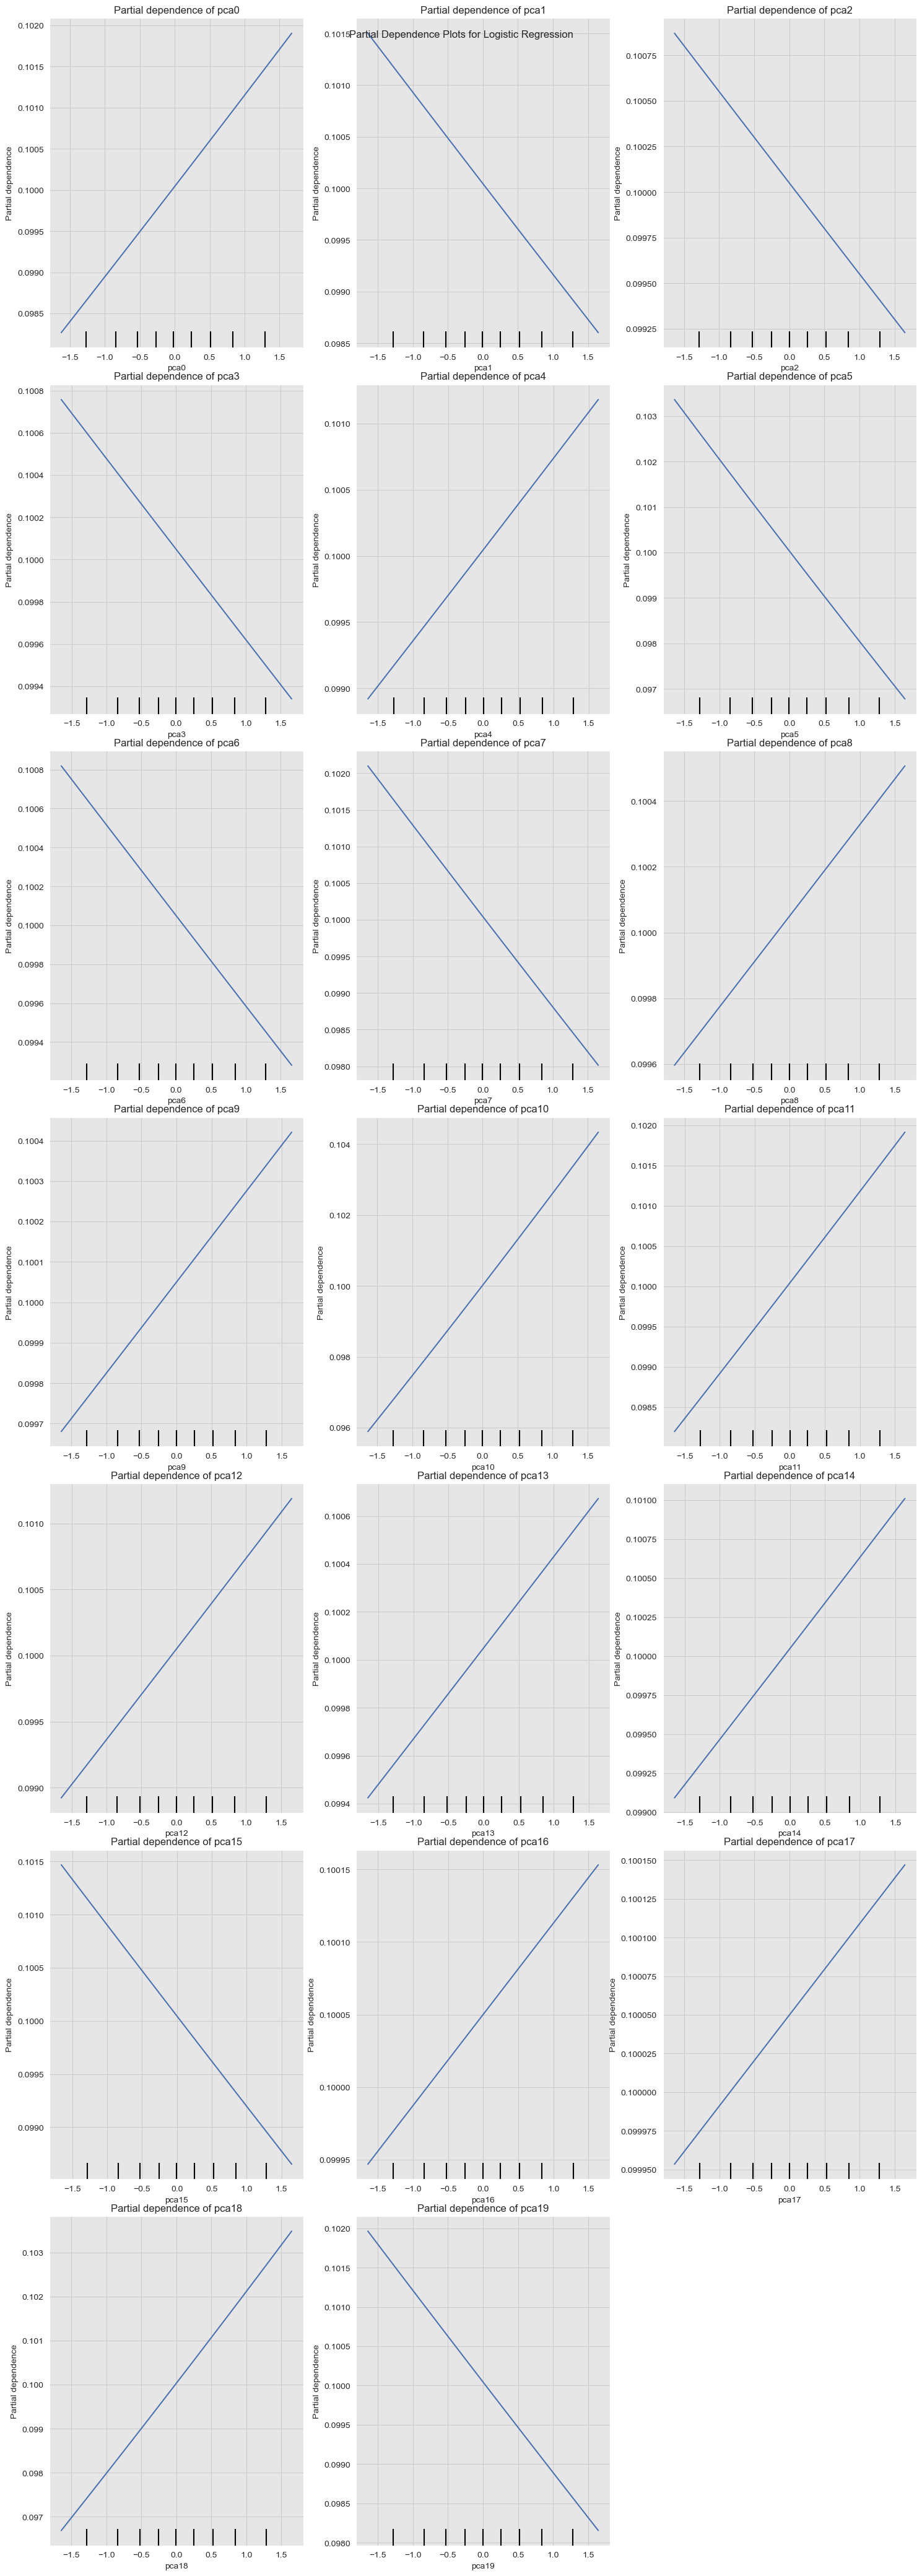

In [122]:
plt = get_partial_dependencies_plot(lr, X_train, modelname='Logistic Regression', save=True)
plt.show()


### Hyperparameter Tuning

This is a process of adjusting the parameters of a model to optimize its performance. It can be done using techniques like grid search, random search, or Bayesian optimization.


In [123]:
# Define the parameter grid to search over
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }
# Define the parameter grid
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear', 'saga']
}


### Grid Search


In [124]:
len(X_test)

100000

Best parameters found: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score found: 0.8519231173822991
Test score with best parameters: 0.8519231171196782


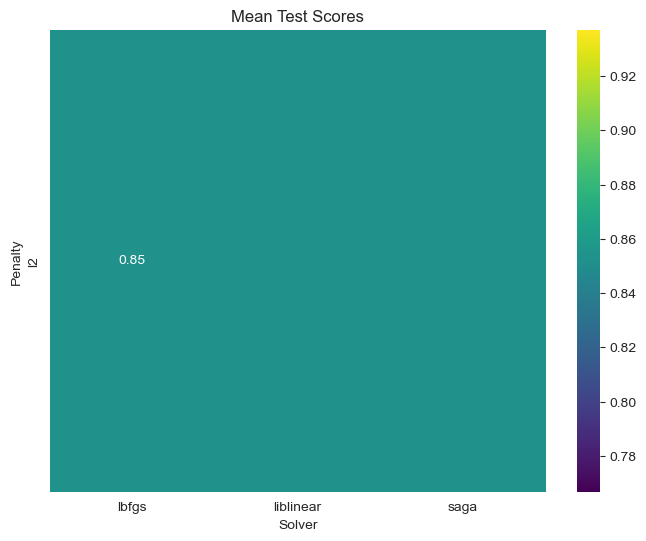

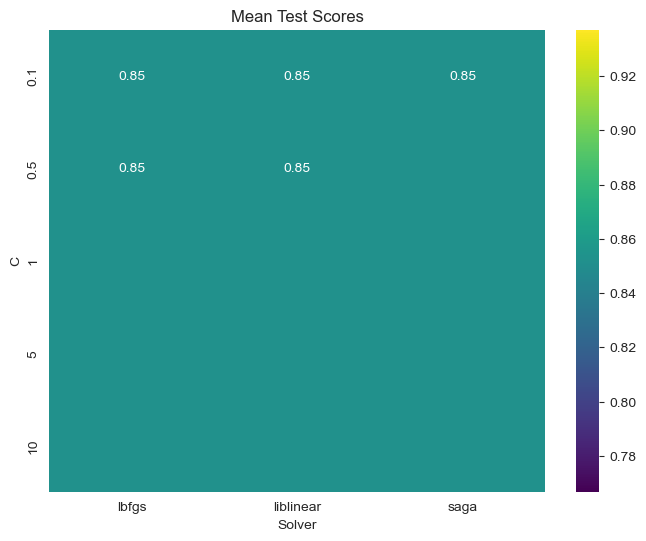

In [125]:
grid_search = get_grid_search(estimator=LogisticRegression(random_state=42,
    max_iter=10000,class_weight=class_weight), param_grid=param_grid, X=X, y=y, cv=NUM_FOLDS, scoring='f1_weighted')
# Print the results
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print("Test score with best parameters:", grid_search.score(X_test, y_test))
# Get the results
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

# Prepare the hyperparameter values for plotting
param_values_C = param_grid['C']
param_values_penalty = param_grid['penalty']
param_values_solver = param_grid['solver']

# Reshape the mean test scores for plotting
mean_test_scores = np.array(mean_test_scores).reshape(len(param_values_C), len(param_values_penalty), len(param_values_solver))

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of mean test scores
sns.heatmap(mean_test_scores.mean(axis=0), annot=True, cmap='viridis', xticklabels=param_values_solver, yticklabels=param_values_penalty)

# Set labels and title
plt.xlabel('Solver')
plt.ylabel('Penalty')
plt.title('Mean Test Scores')

# save the plot
plt.savefig(f'../images/{model_name}/mean_test_scores_1.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of mean test scores
sns.heatmap(mean_test_scores.mean(axis=1), annot=True, cmap='viridis', xticklabels=param_values_solver, yticklabels=param_values_C)

# Set labels and title
plt.xlabel('Solver')
plt.ylabel('C')
plt.title('Mean Test Scores')

# save the plot
plt.savefig(f'../images/{model_name}/mean_test_scores_2.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [126]:
best_parameters = {
    "max_iter":10000,
    "random_state": 42,
    "class_weight":class_weight,
    **grid_search.best_params_
}
print(best_parameters)

{'max_iter': 10000, 'random_state': 42, 'class_weight': None, 'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


accuracy:  0.8995099999999999
f1_macro:  0.47354844130885043
f1_micro:  0.8995099999999999
Accuracy Score of LogisticRegression(C=0.1, max_iter=10000, random_state=42) is: 0.89951


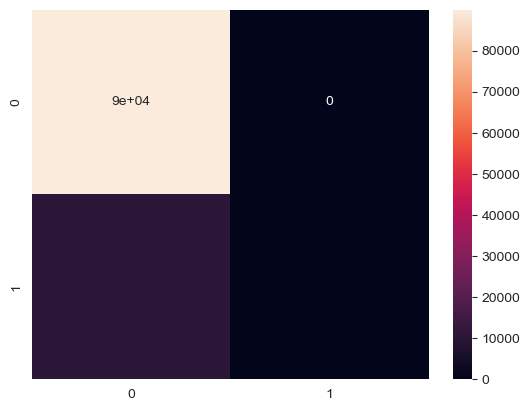

Classification Report of LogisticRegression(C=0.1, max_iter=10000, random_state=42) is: 
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     89951
           1       0.00      0.00      0.00     10049

    accuracy                           0.90    100000
   macro avg       0.45      0.50      0.47    100000
weighted avg       0.81      0.90      0.85    100000

F1 Score of LogisticRegression(C=0.1, max_iter=10000, random_state=42) is: 0.8519231171196782


c:\Users\peter\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
model = LogisticRegression(**best_parameters)
# train the model
model.fit(X, y)
# validate the model
cv_results = cross_validate(model, X, y, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

# predict the validation set
y_pred = model.predict(X_test)

# Accuracy Score
print("Accuracy Score of " + str(model) + " is: " + str(accuracy_score(y_test, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
# save the plot
plt.savefig(f'../images/{model_name}/evaluation_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("Classification Report of " + str(model) + " is: \n" + str(classification_report(y_test, y_pred)))

# Weighted F1 Score
print("F1 Score of " + str(model) + " is: " + str(f1_score(y_test, y_pred, average='weighted')))

### Heatmap


<module 'matplotlib.pyplot' from 'c:\\Users\\peter\\miniconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

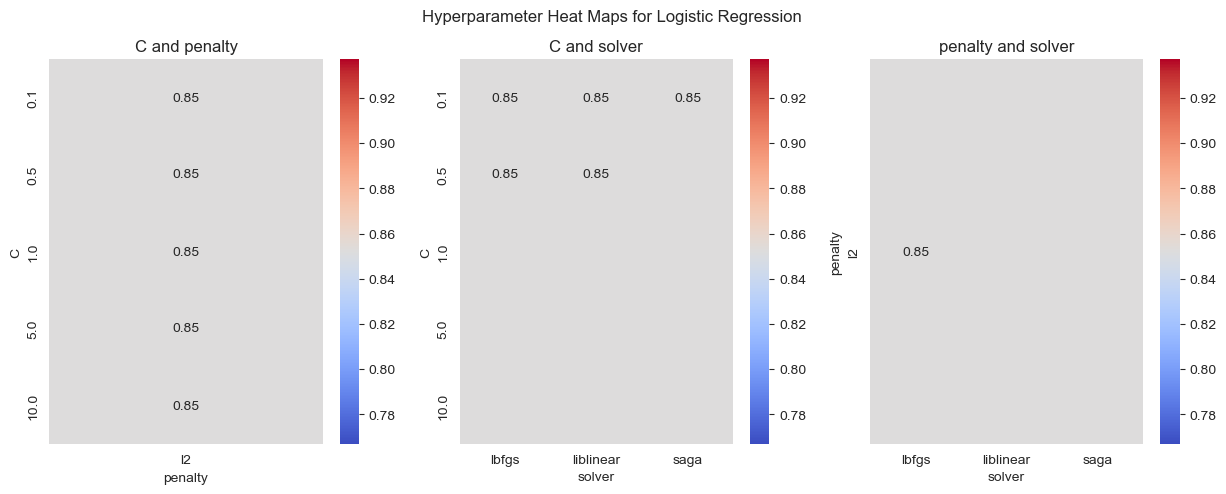

In [128]:
plot_hyper_param_heat_maps(param_grid, grid_search,modelname='Logistic Regression')


### Train-Validation Curve


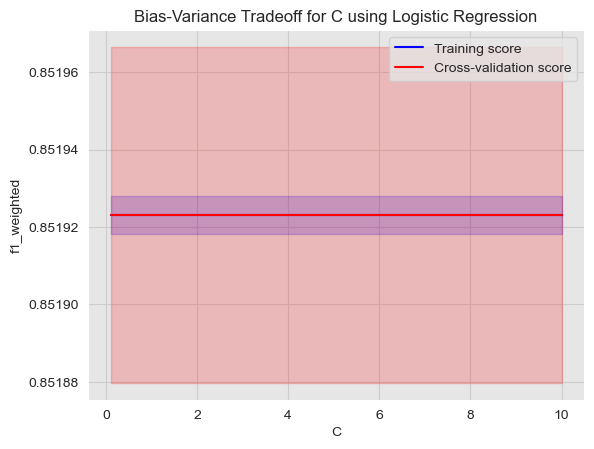

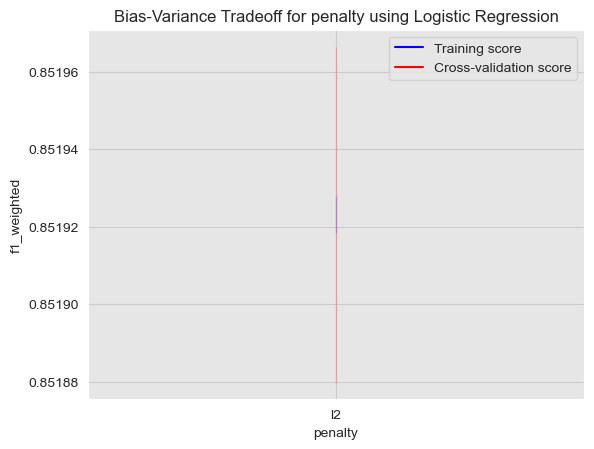

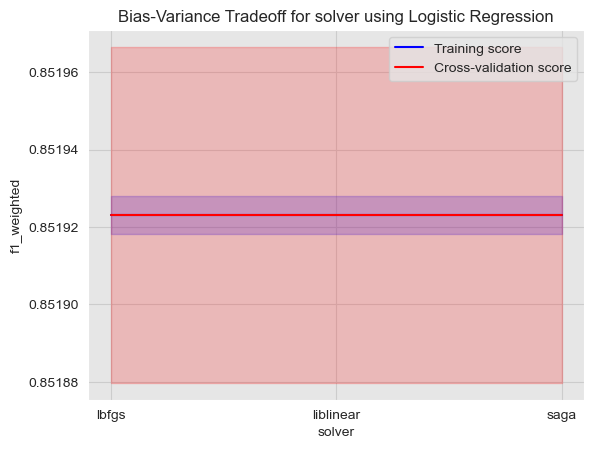

In [129]:
plot_hyper_param_train_validation_curve(estimator=LogisticRegression(random_state=42,
    max_iter=10000,class_weight=class_weight), param_grid=param_grid, X=X, y=y, cv=NUM_FOLDS, scoring='f1_weighted', modelname='Logistic Regression')


## Bias-Variance Analysis


In [130]:
lr = LogisticRegression(**best_parameters)
mse, bias, var = get_bias_variance(
    lr, X_train=X, y_train=y, X_test=X_test, y_test=y_test)


In [131]:
print("mse: ", mse)
print("bias: ", bias)
print("var: ", var)
print("Estimated Eout: ",bias + var)


mse:  0.10049
bias:  0.10049
var:  0.0
Estimated Eout:  0.10049


AUC: 0.50
False Positive Rate: [0. 1.]
True Positive Rate: [0. 1.]
Thresholds: [inf  0.]


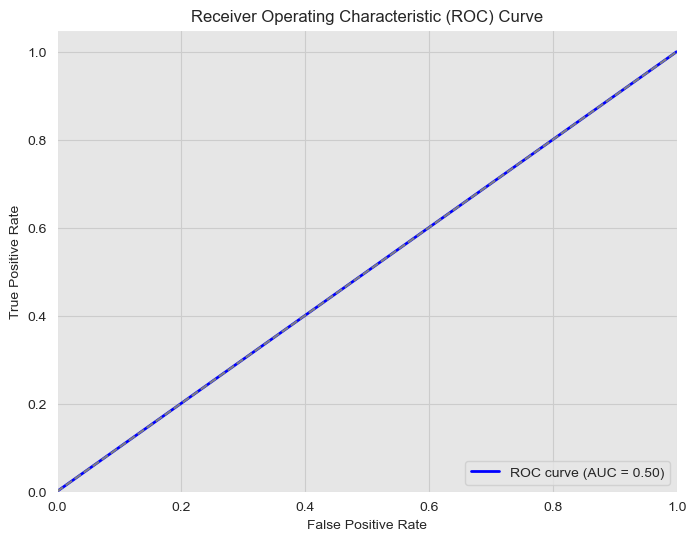

In [132]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred)
print('AUC: %.2f' % roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(f"False Positive Rate: {fpr}")
print(f"True Positive Rate: {tpr}")
print(f"Thresholds: {thresholds}")
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# save
plt.savefig(f'../images/{model_name}/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [133]:
# number of samples of class 0 and 1
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 71996, 1: 8004}
